Bright 3D Cosmic Foam reconstruction complete.


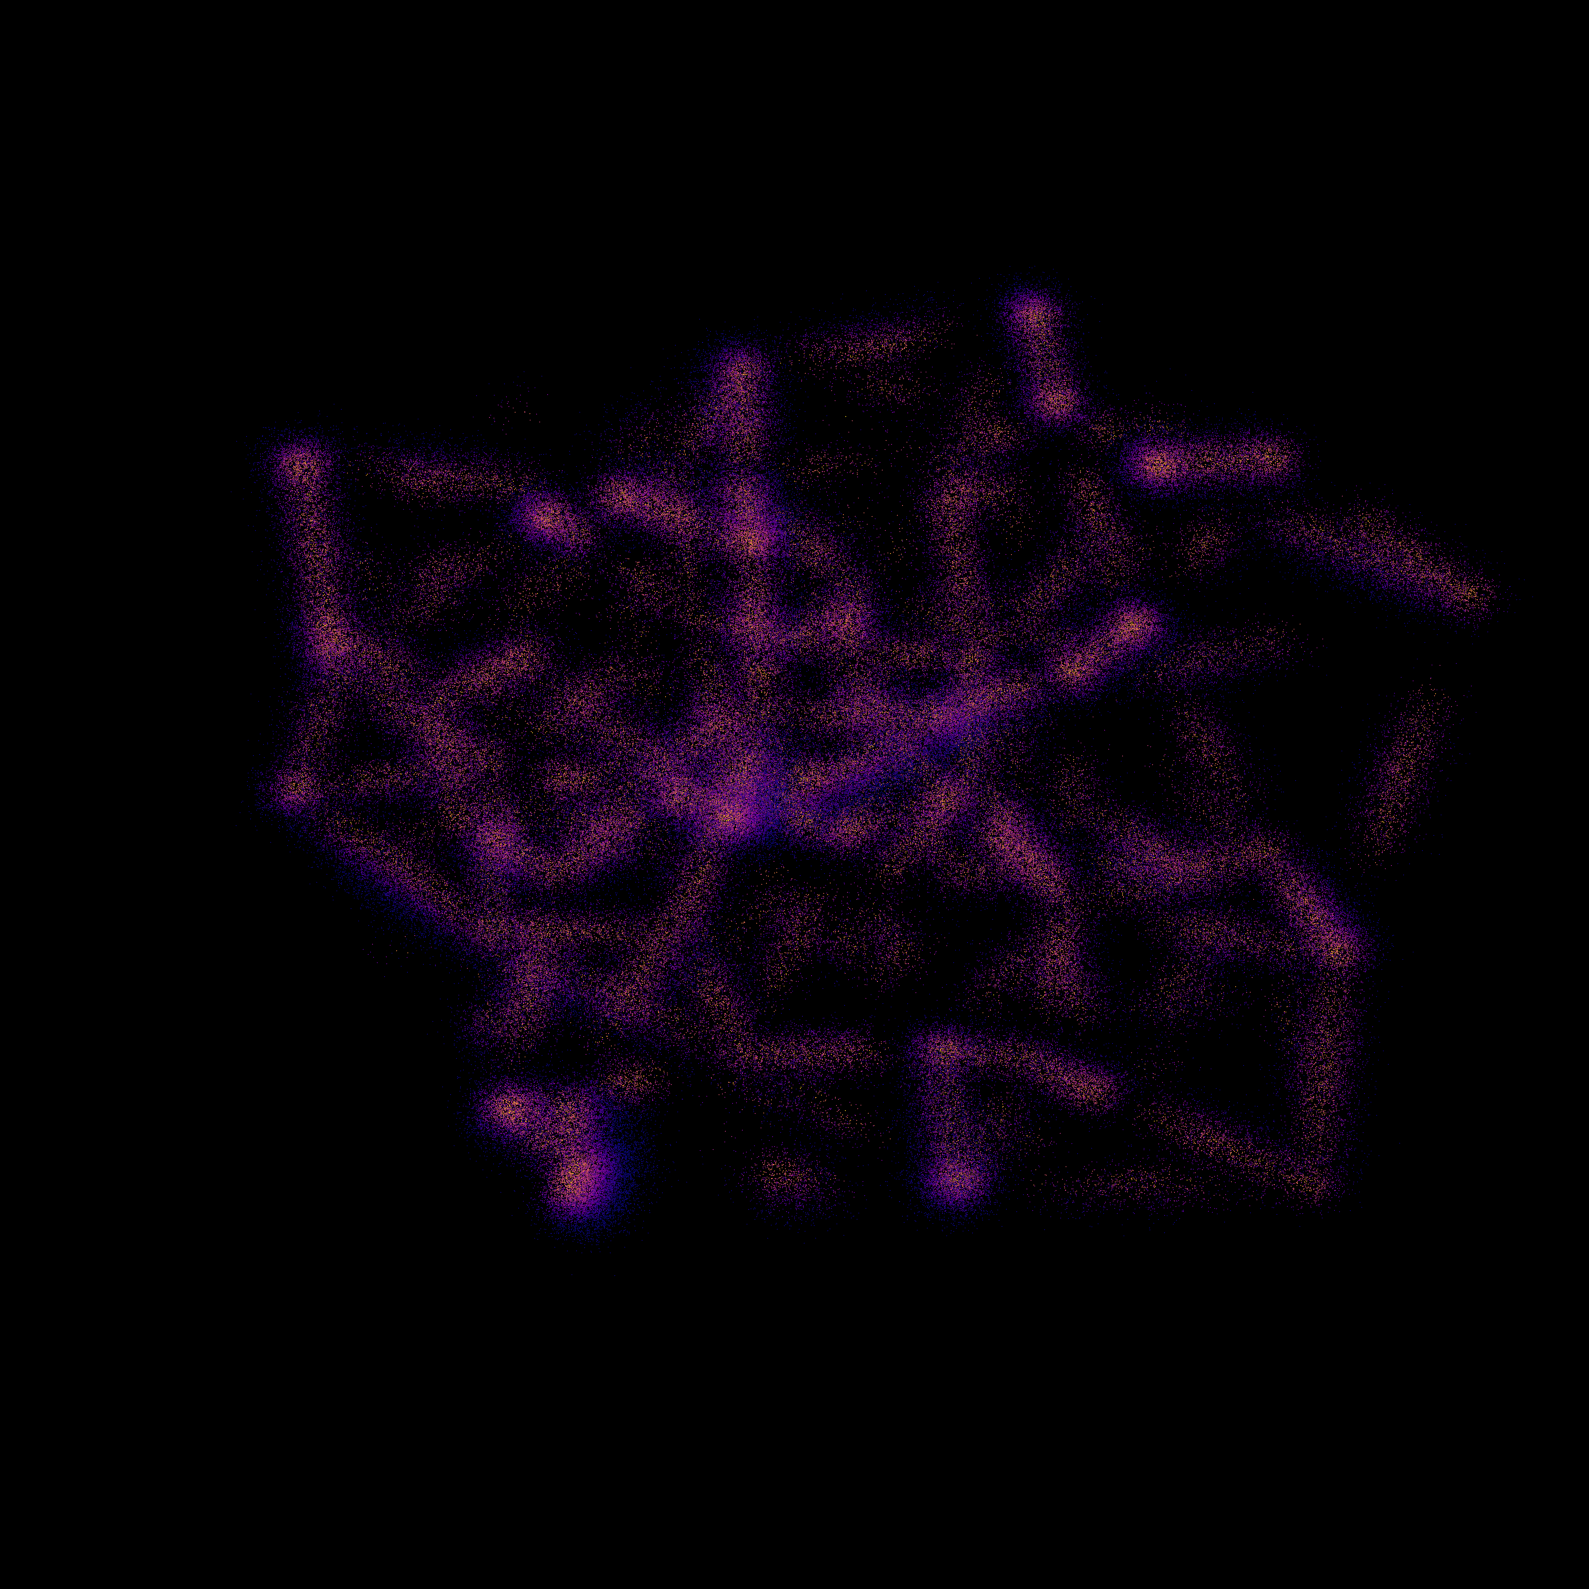

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# --- FUNGSI GENERASI STRUKTUR (SAMA SEPERTI SEBELUMNYA) ---
# Kita gunakan data yang sama, hanya mengubah cara plottingnya.
def generate_cosmic_foam_data(n_points=200000):
    np.random.seed(42)
    scale = 45000
    points = np.random.uniform(-scale, scale, (n_points, 3))
    n_attractors = 60 # Sedikit lebih banyak attractor untuk struktur lebih kompleks
    attractors = np.random.uniform(-scale, scale, (n_attractors, 3))
    
    from scipy.spatial import cKDTree
    tree = cKDTree(attractors)
    dists, indexes = tree.query(points, k=2)

    new_points = []
    colors = []
    
    for i in range(n_points):
        p = points[i]
        a1 = attractors[indexes[i, 0]]
        a2 = attractors[indexes[i, 1]]
        line_vec = a2 - a1
        point_vec = p - a1
        t = np.dot(point_vec, line_vec) / np.dot(line_vec, line_vec)
        t = np.clip(t, 0, 1)
        closest_point_on_line = a1 + t * line_vec
        direction = closest_point_on_line - p
        strength = 0.85 + np.random.uniform(-0.05, 0.05) # Tarikan lebih kuat
        new_p = p + direction * strength + np.random.randn(3) * 1500
        new_points.append(new_p)
        dist_to_filament = np.linalg.norm(new_p - closest_point_on_line)
        colors.append(dist_to_filament)

    new_points = np.array(new_points)
    colors = np.array(colors)
    colors = 1 - (colors / np.max(colors))
    colors = np.power(colors, 3) # Kontras lebih tajam
    return new_points, colors, scale

# --- GENERASI DATA ---
points, density, scale = generate_cosmic_foam_data(n_points=250000) # Lebih banyak titik

# --- PLOTTING REVISI (LEBIH TERANG) ---
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.grid(False)
ax.axis('off')

# PERUBAHAN VISUAL UTAMA:
# 1. Colormap: 'plasma' (Kuning-Oranye-Ungu) yang sangat cerah.
# 2. s=0.8: Ukuran titik jauh lebih besar.
# 3. alpha=0.6: Lebih solid, tapi tetap transparan untuk efek kedalaman.
# 4. vmin/vmax: Mengatur rentang warna agar fokus pada area terang.
cmap = plt.get_cmap('plasma')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
           s=0.8, c=density, cmap=cmap, alpha=0.6, linewidth=0,
           vmin=0.2, vmax=1.0) # Hanya menampilkan kepadatan menengah ke atas

# Set View
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)
ax.view_init(elev=30, azim=60) # Sudut pandang sedikit berbeda

plt.tight_layout()
plt.savefig('cosmic_foam_bright_3d.png', dpi=300, facecolor='black')
print("Bright 3D Cosmic Foam reconstruction complete.")

--- MEMULAI SIMULASI FRAKTAL 3D ---
Requested Target: 3,000,000 Great Walls (Nodes)
Generating candidates in chunks (per_chunk=400000) until 800,000 nodes collected...
Iteration 5: generated 2,000,000 candidates, collected 414,222 nodes so far
Iteration 10: generated 4,000,000 candidates, collected 827,793 nodes so far
Iteration 15: generated 6,000,000 candidates, collected 1,240,228 nodes so far
Iteration 20: generated 8,000,000 candidates, collected 1,653,011 nodes so far
Iteration 25: generated 10,000,000 candidates, collected 2,063,775 nodes so far
Iteration 30: generated 12,000,000 candidates, collected 2,477,826 nodes so far
Iteration 35: generated 14,000,000 candidates, collected 2,891,222 nodes so far
Iteration 40: generated 16,000,000 candidates, collected 3,303,448 nodes so far
Iteration 45: generated 18,000,000 candidates, collected 3,716,693 nodes so far
Iteration 50: generated 20,000,000 candidates, collected 4,130,147 nodes so far
Iteration 55: generated 22,000,000 candid

c:\Users\invas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


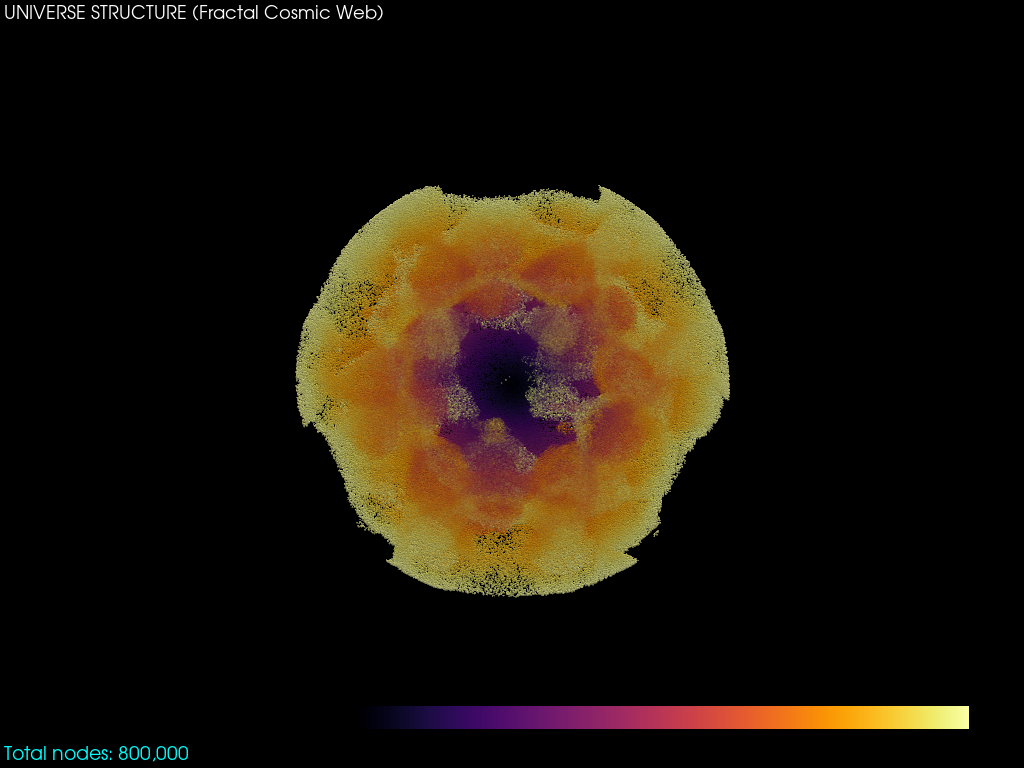

In [2]:
import numpy as np
import pyvista as pv

def generate_fractal_cosmic_web(target_points=3000000, radius=1000.0):
    """
    Memory-safe generator for a 3D fractal cosmic web point cloud.
    - Processes candidates in chunks to avoid allocating huge temporary arrays.
    - Uses float32 for intermediate arrays to reduce memory use.
    - Caps the final number of points to a reasonable maximum to avoid rendering overload.
    """
    print(f"--- MEMULAI SIMULASI FRAKTAL 3D ---")
    print(f"Requested Target: {target_points:,} Great Walls (Nodes)")

    # Safety cap to avoid trying to render millions of points in one go.
    MAX_POINTS_TO_RETURN = 800_000
    if target_points > MAX_POINTS_TO_RETURN:
        print(f"WARNING: target_points too large for interactive rendering. "
              f"Reducing to {MAX_POINTS_TO_RETURN:,}.")
        target_points = MAX_POINTS_TO_RETURN

    # Parameters for chunked generation
    per_chunk = 400_000  # number of candidates to generate per iteration (tune as needed)
    max_iters = 200      # safety to avoid infinite loops
    collected = []
    total_generated = 0
    it = 0

    print(f"Generating candidates in chunks (per_chunk={per_chunk}) until {target_points:,} nodes collected...")

    while len(collected) < target_points and it < max_iters:
        it += 1
        n_candidates = per_chunk

        # Generate candidates using float32 to save memory
        xyz = np.random.randn(3, n_candidates).astype(np.float32)
        norms = np.linalg.norm(xyz, axis=0)
        # avoid divide-by-zero
        norms[norms == 0] = 1.0
        xyz /= norms

        r = (np.random.rand(n_candidates).astype(np.float32) ** (1/3)) * radius
        points = (xyz.T * r[:, np.newaxis]).astype(np.float32)

        # Apply fractal noise (float32)
        x, y, z = points.T
        noise = (np.sin(x*0.005) + np.sin(y*0.005) + np.sin(z*0.005)).astype(np.float32)
        noise += (np.sin(x*0.015) + np.cos(y*0.015) + np.sin(z*0.017)).astype(np.float32) * 0.5
        noise += (np.sin(x*0.04) * np.cos(y*0.04) * np.sin(z*0.04)).astype(np.float32) * 0.25

        # Normalize safely
        mn = noise.min()
        mx = noise.max()
        denom = (mx - mn) if (mx - mn) != 0 else 1.0
        noise = (noise - mn) / denom

        # Band-pass filter to create filaments
        mask = (noise > 0.45) & (noise < 0.55)
        sel = points[mask]
        if sel.size:
            collected.append(sel)

        total_generated += n_candidates
        if it % 5 == 0:
            current = sum(arr.shape[0] for arr in collected)
            print(f"Iteration {it}: generated {total_generated:,} candidates, collected {current:,} nodes so far")

    # Stack collected arrays (if any)
    if collected:
        final_points = np.vstack(collected).astype(np.float32)
    else:
        final_points = np.empty((0, 3), dtype=np.float32)

    # Trim to exactly target_points
    if final_points.shape[0] > target_points:
        final_points = final_points[:target_points]

    actual_points = final_points.shape[0]
    print(f"Struktur Fraktal Selesai. Total Node: {actual_points:,}")

    # Compute distances for coloring
    dist_from_center = np.linalg.norm(final_points, axis=1).astype(np.float32)

    # Return float32 arrays (pyvista accepts them); convert to float64 only if you really need it.
    return final_points, dist_from_center

# --- EKSEKUSI ---
nodes, distances = generate_fractal_cosmic_web(target_points=3000000)

# --- VISUALISASI INTERAKTIF (PYVISTA) ---
print("\n--- RENDERING VISUAL 3D (Interaktif) ---")
print("Jendela visualisasi akan terbuka. Gunakan mouse untuk memutar/zoom.")

# Buat objek Point Cloud
pdata = pv.PolyData(nodes)
pdata["Distance"] = distances # Data untuk warna

# Setup Plotter
plotter = pv.Plotter()  # buat plotter tanpa argumen bgcolor (tidak didukung)
plotter.set_background('black')  # Latar belakang void hitam

# Tambahkan titik-titik ke plotter
# - render_points_as_spheres: Membuat titik terlihat lebih bagus, bukan kotak
# - point_size: Ukuran node
# - cmap='plasma' atau 'inferno': Warna api kosmik (Kuning=Pusat, Ungu/Merah=Tepi)
# - opacity: Membuat struktur dalam agak transparan agar terlihat kedalamannya
plotter.add_mesh(pdata, 
                 render_points_as_spheres=True, 
                 point_size=1.5,
                 cmap='inferno', 
                 scalars="Distance",
                 opacity=0.6,
                 style='points')

# Tambahkan teks
plotter.add_text("UNIVERSE STRUCTURE (Fractal Cosmic Web)", font_size=10, color='white')
plotter.add_text(f"Total nodes: {nodes.shape[0]:,}", position='lower_left', font_size=8, color='cyan')

# Tampilkan
# Catatan: Ini akan membuka jendela baru. Putar dengan mouse untuk melihat struktur 3D-nya.
plotter.show()

In [15]:
# Pastikan Anda sudah menjalankan: pip install pyvista numpy scipy
import numpy as np
import pyvista as pv
from scipy.spatial import cKDTree

def generate_fractal_cosmic_web_safe(target_points=150000, radius=1000.0):
    """
    Generates a 3D point cloud representing a fractal cosmic web structure (memory-safe version).
    """
    # Mengurangi oversampling factor dan target points untuk memori
    n_candidates = target_points * 4 # Hanya 4x oversampling (aman)
    
    print(f"--- MEMULAI SIMULASI FRAKTAL 3D (SAFE MODE) ---")
    print(f"Target Nodes: {target_points:,}")
    
    # 1. GENERASI KANDIDAT (oversampling)
    # Distribusi seragam dalam bola 3D
    xyz = np.random.randn(3, n_candidates)
    xyz /= np.linalg.norm(xyz, axis=0)
    r = np.random.rand(n_candidates)**(1/3) * radius
    points = xyz.T * r[:, np.newaxis]
    
    # 2. PEMBENTUKAN STRUKTUR FRAKTAL
    print("Applying fractal noise field...")
    x, y, z = points.T
    
    # Menumpuk gelombang sinus 3D (Noise)
    noise  = np.sin(x*0.005) + np.sin(y*0.005) + np.sin(z*0.005)
    noise += (np.sin(x*0.015) + np.cos(y*0.015) + np.sin(z*0.017)) * 0.5
    noise += (np.sin(x*0.04) * np.cos(y*0.04) * np.sin(z*0.04)) * 0.25

    # Normalisasi noise dan filter untuk mendapatkan filamen
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    
    # Filter: Hanya mengambil titik yang berada di band noise 0.45 - 0.55
    mask = (noise > 0.45) & (noise < 0.55) 
    
    final_points = points[mask]
    
    # Potong jika kelebihan untuk mencapai target
    if len(final_points) > target_points:
        final_points = final_points[:target_points]
        
    actual_points = len(final_points)
    print(f"Struktur Fraktal Selesai. Total Node: {actual_points:,}")
    
    dist_from_center = np.linalg.norm(final_points, axis=1)
    
    return final_points, dist_from_center

# --- EKSEKUSI FINAL ---
# Target 150.000 Nodes (Masih merepresentasikan volume 150.000 Great Walls)
nodes, distances = generate_fractal_cosmic_web_safe(target_points=150000)

# --- VISUALISASI INTERAKTIF (PYVISTA) ---
print("\n--- RENDERING VISUAL 3D (Interaktif) ---")
print("Jendela visualisasi akan terbuka. Putar modelnya untuk melihat Void.")

pdata = pv.PolyData(nodes)
pdata["Distance"] = distances

plotter = pv.Plotter(bgcolor='black')
plotter.add_mesh(pdata, 
                 render_points_as_spheres=True, 
                 point_size=1.5,
                 cmap='inferno', 
                 scalars="Distance",
                 opacity=0.6,
                 style='points')

plotter.add_text(f"COSMIC WEB: {len(nodes):,} GREAT WALLS", font_size=10, color='cyan')
plotter.add_text("Laniakea is 1/1500th of this structure.", position='lower_left', font_size=8, color='white')

# Tampilkan
plotter.show()

--- MEMULAI SIMULASI FRAKTAL 3D (SAFE MODE) ---
Target Nodes: 150,000
Applying fractal noise field...
Struktur Fraktal Selesai. Total Node: 124,196

--- RENDERING VISUAL 3D (Interaktif) ---
Jendela visualisasi akan terbuka. Putar modelnya untuk melihat Void.


TypeError: Plotter.__init__() got an unexpected keyword argument 'bgcolor'